# Optimise pruning parameters

This Notebook shows how to optimise the pruning parameters of your network based on pairwise connectivity data.

First we need to create a small network that we can use for the optimisation of the pruning parameters.

In this example we do not need to have realistic neuron densities, so we will place the neurons in a cube of diameter 150 micrometers.

In [1]:
import os
import numpy as np

n_neurons = 150

pop_size = 15
# epochs = 10

pre_type = "TH"     # "iSPN"
post_type = "iSPN"  # "iSPN"
con_type = "GABA"

avg_num_synapses_per_pair = 3  # Expected mean, error weight

# param_names = ["f1", "softMax", "mu2", "a3"]
param_names = ["f1", "mu2", "a3"]

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
FS_dist_dep_pruning = "exp(-(0.5*d/60e-6)**2)" 
LTS_dist_dep_pruning = "1-exp(-(0.4*d/60e-6)**2)"


extra_pruning_parameters = { }
# extra_pruning_parameters = { 'distPruning': SPN2SPNdistDepPruning }
    
        
par_str = "_".join(param_names)
network_path = os.path.join("networks", f"{pre_type}_to_{post_type}_{par_str}")

        
all_experimental_data = {}
all_experimental_data["dSPN", "iSPN"] = [(0, 50e-6, 3/47.0), (0, 100e-6, 3/66.0)]
all_experimental_data["dSPN", "dSPN"] = [(0, 50e-6, 5/19.0), (0, 100e-6, 3/43.0)]
all_experimental_data["iSPN", "iSPN"] = [(0, 50e-6, 14/39.0), (0, 100e-6, 7/31.0)]
all_experimental_data["iSPN", "dSPN"] = [(0, 50e-6, 13/47.0), (0, 100e-6, 10/80.0)]

all_experimental_data["FS", "FS"] = [(0, 250e-6, 7/12.0)]
all_experimental_data["FS", "iSPN"] = [(0, 100e-6, 6/9.0), (0, 150e-6, 21/54.0), (0, 250e-6, 27/77.0)]
all_experimental_data["FS", "dSPN"] = [(0, 100e-6, 8/9.0), (0, 150e-6, 29/48.0), (0, 250e-6, 48/90.0)]
all_experimental_data["FS", "LTS"] = [(0, 250e-6, 2/12.0)]

all_experimental_data["LTS", "dSPN"] = [(0, 250e-6, 2/60.0)]
all_experimental_data["LTS", "iSPN"] = [(0, 250e-6, 2/60.0)]

all_experimental_data["ChIN", "dSPN"] = [(0, 250e-6, 0.05)]
all_experimental_data["ChIN", "iSPN"] = [(0, 250e-6, 0.05)]
all_experimental_data["ChIN", "LTS"] = [(0, 250e-6, 53/72.0)]  # Lou ea 2013
all_experimental_data["ChIN", "FS"] = [(0, 250e-6, 19/26.0)]   # Lou ea 2013



all_experimental_data["NGF", "dSPN"] = [(0, 100e-6, 25/29.0),  # Ibanez-Sandoval 2011
                                        (0, 250e-6, 11/14.0),  # English 2012
                                        (0, 250e-6, 30/50.0)]  # Luo 2013
all_experimental_data["NGF", "iSPN"] = [(0, 100e-6, 25/29.0),  # Ibanez-Sandoval 2011
                                        (0, 250e-6, 11/14.0),  # English 2012
                                        (0, 250e-6, 30/50.0)]  # Luo 2013
all_experimental_data["NGF", "ChIN"] = [(0, 250e-6, 3/14.0)]  # English 2012

# NGF to FS??   Kocaturk 2022 -- no probability given?
# NGF to NGF??

# IB should be 20-26 micrometers, TODO: Fix the code so it can handle start point larger than 0!!

all_experimental_data["TH", "dSPN"] = [(0, 60e-6, 5/36.0),  # Ibanez-Sandoval 2010
                                        (0, 100e-6, 13/44.0)]  # Luo 2013

all_experimental_data["TH", "iSPN"] = [(0, 60e-6, 5/36.0),  # Ibanez-Sandoval 2010
                                        (0, 100e-6, 13/44.0)]  # Luo 2013


experimental_data = all_experimental_data[pre_type, post_type]

cube_side = np.max([x[1] for x in experimental_data])

axon_cloud = dict()
LTS_density_str = ("12*3000*1e12*( 0.25*exp(-(((x-200e-6)/100e-6)**2 "
                           "+ ((y-0)/50e-6)**2 + ((z-0)/30e-6)**2)) "
                           "+ 1*exp(-(((x-300e-6)/300e-6)**2 + ((y-0)/15e-6)**2 + ((z-0)/10e-6)**2)) "
                           "+ 1*exp(-(((x-700e-6)/100e-6)**2 + ((y-0)/15e-6)**2 + ((z-0)/15e-6)**2)) )")

axon_cloud["LTS"] = ("xyz", LTS_density_str, [-200e-6, 900e-6, -100e-6, 100e-6, -30e-6, 30e-6])
# axon_cloud["CHIN"] = ("r", "5000*1e12/3*exp(-r/120e-6)", 350e-6)

In [2]:
from snudda.place.create_cube_mesh import create_cube_mesh

mesh_file = os.path.join(network_path, "cube-mesh.obj")
create_cube_mesh(mesh_file, [0,0,0], cube_side)

from snudda.init import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=123, snudda_data="../../../../../BasalGangliaData/data/")

si.define_structure(struct_name="Cube", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)

if pre_type in axon_cloud:
    pre_ac = axon_cloud[pre_type]
else:
    pre_ac = None
    
if post_type in axon_cloud:
    post_ac = axon_cloud[post_type]
else:
    post_ac = None

if pre_type == post_type:
    
    si.add_neurons(name=pre_type, num_neurons=n_neurons, volume_id="Cube", axon_density=pre_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum",pre_type.lower()))
else:
    si.add_neurons(name=pre_type, num_neurons=int(n_neurons/2), volume_id="Cube", axon_density=pre_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum", pre_type.lower()))
    si.add_neurons(name=post_type, num_neurons=int(n_neurons/2), volume_id="Cube", axon_density=post_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum", post_type.lower()))
    

# The parameters here does not matter, they will be set during optimisation
si.add_neuron_target(neuron_name=pre_type,
                     target_name=post_type,
                     region_name="Cube",
                     connection_type=con_type,
                     dist_pruning=None,
                     f1=None, soft_max=None, mu2=None,
                     a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     mod_file="tmGabaA")

si.write_json()

Adding neurons: TH from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/th
Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn
Writing networks/TH_to_iSPN_f1_mu2_a3/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/TH_to_iSPN_f1_mu2_a3/network-config.json
No n_putative_points and putative_density, setting n_putative_points = 572
(this must be larger than the number of neurons you want to place)
Generating 572 points for networks/TH_to_iSPN_f1_mu2_a3/cube-mesh.obj
Filtering, keeping inside points: 163 / 321
neuron_name = 'TH_0', num = 75, neuron_path = '/home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/th/cell1'
neuron_name = 'iSPN_0', num = 18, neuron_path = '/home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn/str-ispn-e150908_c4_D2-m51-5-DE-v20220622'
neuron_name = 'iSPN_1', num = 19, neuron_path = '/home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn/str-ispn-e150917_c11_D2-mWT-MSN1-v20220623'
neuron_name = 'iSPN_2', num = 19, neuron_path = '/home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn/str-ispn-e151123_c1_D2-mWT-P270-09-v20220623'
neuron_name = 'iSPN_3', num = 19, neuron_path = '/home

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/TH_to_iSPN_f1_mu2_a3/network-config.json


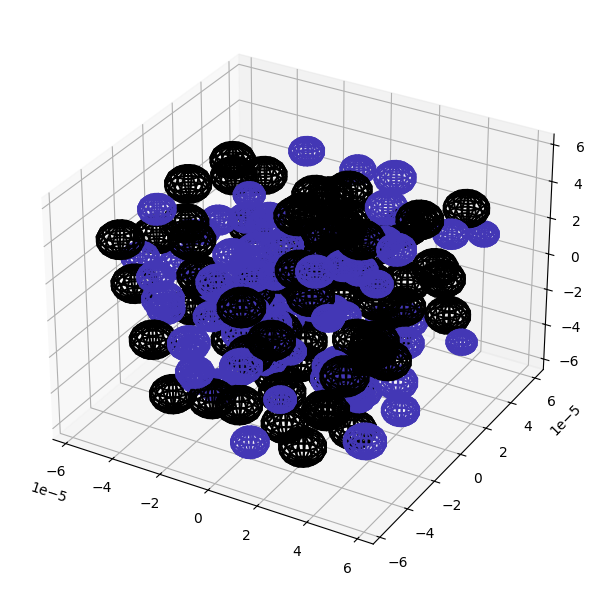

In [4]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=100)
sd.detect()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/TH_to_iSPN_f1_mu2_a3/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 21/64 (150 neurons)
Processing hyper voxel : 5/64 (122 neurons)
Processing hyper voxel : 20/64 (111 neurons)
Processing hyper voxel : 17/64 (108 neurons)
Processing hyper voxel : 22/64 (53 neurons)
Processing hyper voxel : 4/64 (50 neurons)
Processing hyper voxel : 1/64 (49 neurons)
Processing hyper voxel : 25/64 (41 neurons)
Processing hyper voxel : 16/64 (39 neurons)
Processing hyper voxel : 37/64 (31 neurons)
Processing hyper voxel : 6/64 (20 neurons)
Processing hyper voxel : 24/64 (16 neurons)
Processing hyper voxel : 9/64 (14 neurons)
Processing hyper voxel : 18/64 (12 neurons)
Processing hyper voxel : 0/64 (11 neurons)
Processing hyper voxel : 36/64 (9 neurons)
Processing hyper voxel : 33/64 (8 neurons)
Processing hyper voxel : 8/64 (7 neurons)
Processing hyper voxel : 38/64 (5 neurons)

In [6]:
from snudda.optimise.optimise_pruning import OptimisePruning
op = OptimisePruning(network_path=network_path)

In [7]:
op.merge_putative_synapses(force_merge=True)

Read 6981 out of total 6981 synapses


In [8]:
op.prune.connectivity_distributions

{(1,
  2,
  10): ({'f1': 1.0,
   'soft_max': None,
   'mu2': None,
   'a3': None,
   'dist_pruning': None,
   'cluster_pruning': False}, None)}

In [9]:
op.prune.type_id_lookup

{'TH': 1, 'iSPN': 2}

In [10]:
op.prune.hist_file["meta/connectivity_distributions"][()]

b'{"TH$$iSPN": {"GABA": {"conductance": [2.4e-10, 1e-10], "channel_parameters": {"mod_file": "tmGabaA"}, "cluster_size": 1, "cluster_spread": null, "pruning": {"f1": null, "soft_max": null, "mu2": null, "a3": null, "dist_pruning": null, "cluster_pruning": false}, "channel_model_id": 10, "lognormal_mu_sigma": [-22.230424900260093, 0.40010675493807013]}}}'

In [11]:
res = op.optimize(pre_type=pre_type, post_type=post_type, con_type=con_type, 
                  experimental_data=experimental_data, 
                  avg_num_synapses_per_pair=avg_num_synapses_per_pair,
                  extra_pruning_parameters=extra_pruning_parameters, 
                  workers=8, maxiter=1000, pop_size=pop_size, tol=0.00001, 
                  param_names=param_names, param_bounds="default")

/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Worker iter: 100, fitness 25.50449864842694
Worker iter: 100, fitness 25.53621511025092
Worker iter: 100, fitness 25.633390846009256
Worker iter: 100, fitness 25.746390238349903
Worker iter: 100, fitness 25.420700777921333
Worker iter: 100, fitness 26.018309068999027
Worker iter: 100, fitness 25.56381699537029
Worker iter: 100, fitness 25.456793664867405
Worker iter: 200, fitness 25.292766056221485
Worker iter: 200, fitness 25.31408632359785
Worker iter: 200, fitness 25.265600861319662
Worker iter: 200, fitness 25.37178354216389
Worker iter: 200, fitness 25.265600861319662
Worker iter: 200, fitness 25.314329428865822
Worker iter: 200, fitness 25.23793433466835
Worker iter: 200, fitness 25.29610187711397
Worker iter: 300, fitness 25.24125671983213
Worker iter: 300, fitness 25.23793433466835
Worker iter: 300, fitness 25.23793433466835
Worker iter: 300, fitness 25.23793433466835
Worker iter: 300, fitness 25.23793433466835
Worker iter: 300, fitness 25.23793433466835
Worker iter: 300, fitne

In [12]:
op.export_json("network-config-opt.json", res=res, append=True)

# Best parameter set

In [13]:
param_str = ""
for p_name, p_val in zip(param_names, res.x):
    param_str += f"{p_name} = {p_val:.4f}, "
    
if "distPruning" in extra_pruning_parameters:
   param_str += f" ({extra_pruning_parameters['distPruning']})"                                                  
                                                 
print(param_str)

f1 = 0.4039, mu2 = 1.4956, a3 = 1.0000, 


In [14]:
res

             message: Optimization terminated successfully.
             success: True
                 fun: 25.23793433466835
                   x: [ 4.039e-01  1.496e+00  1.000e+00]
                 nit: 67
                nfev: 3064
          population: [[ 4.039e-01  1.496e+00  1.000e+00]
                       [ 4.039e-01  1.496e+00  1.000e+00]
                       ...
                       [ 4.039e-01  1.496e+00  1.000e+00]
                       [ 4.039e-01  1.496e+00  1.000e+00]]
 population_energies: [ 2.524e+01  2.524e+01 ...  2.524e+01  2.524e+01]

In [15]:
import os
from snudda.analyse.analyse import SnuddaAnalyse
import glob

# Get the last file
# list_of_files = glob.glob(os.path.join(network_path, "temp", "network-synapses-*hdf5"))
# network_file = max(list_of_files, key=os.path.getctime)

network_file = os.path.join(network_path, "network-synapses.hdf5")

dist3D = False
y_max_H = None

sa = SnuddaAnalyse(network_file)

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Creating figures directory networks/TH_to_iSPN_f1_mu2_a3/figures
Number of neurons: 150
Synapse row 0 - 0.0 % time: 0.0008583749995523249 seconds
Created connection matrix 0.002906749999965541 seconds
Created gap junction connection matrix 6.833400038885884e-05 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 1861, at 0
Created distance histogram (optimised) in 0.0019186669996997807 seconds
Saving cache to networks/TH_to_iSPN_f1_mu2_a3/network-synapses.hdf5-cache


Plotting connection probability TH to iSPN (synapses)
Centering in None : Keeping 75/75
Counting connections
Requested: 10000000.0 calculated [5625.]
P(d<6e-05) = 0.12788313685289596
P(d<94) = 0.12693333333333334


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1439: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


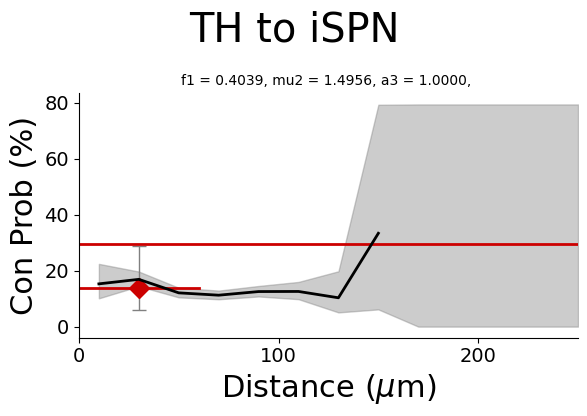

Wrote networks/TH_to_iSPN_f1_mu2_a3/figures/Network-distance-dependent-connection-probability-TH-to-iSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 75/75
Calculating max synapses
Calculating mean synapses
Plotting 714 connections


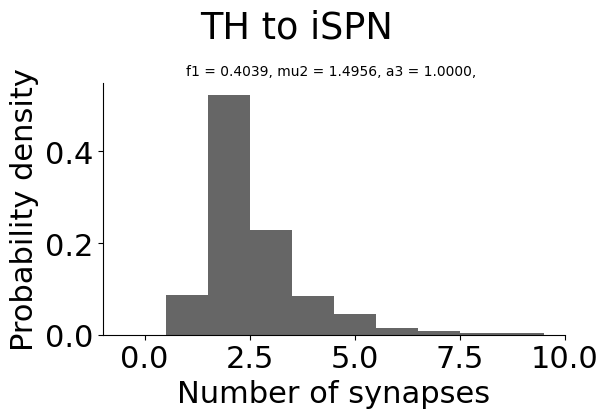

Wrote networks/TH_to_iSPN_f1_mu2_a3/figures/Network-number-of-synapses-from-TH-to-iSPN-per-cell.png


In [17]:
if pre_type == "dSPN" and post_type == "iSPN":
    sa.plot_connection_probability("dSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "iSPN", sub_title=param_str)
elif pre_type == "dSPN" and post_type == "dSPN":
    sa.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(5, 19), (3, 43)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "dSPN", sub_title=param_str)
elif pre_type == "iSPN" and post_type == "iSPN":
    sa.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(14, 39), (7, 31)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "iSPN", sub_title=param_str)
elif pre_type == "iSPN" and post_type == "dSPN":
    sa.plot_connection_probability("iSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(13, 47), (10, 80)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "dSPN", sub_title=param_str)

elif pre_type == "FS" and post_type == "FS":
    sa.plot_connection_probability("FS", "FS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(7, 12)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "FS", sub_title=param_str)
elif pre_type == "FS" and post_type == "iSPN":
    sa.plot_connection_probability("FS", "iSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(6, 9), (21, 54), (27,77)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "iSPN", sub_title=param_str)
elif pre_type == "FS" and post_type == "dSPN":
    sa.plot_connection_probability("FS", "dSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(8, 9), (29, 48), (48,90)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "dSPN", sub_title=param_str)    
elif pre_type == "FS" and post_type == "LTS":
    sa.plot_connection_probability("FS", "LTS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 12)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "LTS", sub_title=param_str)
    
elif pre_type == 'LTS' and post_type == "dSPN":
    sa.plot_connection_probability("LTS", "dSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 60)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "dSPN", sub_title=param_str)
elif pre_type == 'LTS' and post_type == "iSPN":
    sa.plot_connection_probability("LTS", "iSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 60)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "iSPN", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "dSPN":
    sa.plot_connection_probability("ChIN", "dSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data=[0.05], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "dSPN", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "iSPN":
    sa.plot_connection_probability("ChIN", "iSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data=[0.05], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "iSPN", sub_title=param_str)

# Missing pairwise experimental data...
    
elif pre_type == 'ChIN' and post_type == "FS":
    sa.plot_connection_probability("ChIN", "FS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(19, 26)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "FS", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "LTS":
    sa.plot_connection_probability("ChIN", "LTS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(53,72)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "LTS", sub_title=param_str)

elif pre_type == 'LTS' and post_type == "ChIN":
    sa.plot_connection_probability("LTS", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "ChIN", sub_title=param_str)

    
elif pre_type == 'dSPN' and post_type == "ChIN":
    sa.plot_connection_probability("dSPN", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "ChIN", sub_title=param_str)
elif pre_type == 'iSPN' and post_type == "ChIN":
    sa.plot_connection_probability("iSPN", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "ChIN", sub_title=param_str)

elif pre_type == 'NGF' and post_type == "dSPN":
    sa.plot_connection_probability("NGF", "dSPN", dist_3d=True, 
                                   exp_max_dist=[100e-6, 250e-6, 250e-6],
                                   exp_data_detailed=[(25,29), (11,14), (30,50)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "dSPN", sub_title=param_str)
elif pre_type == 'NGF' and post_type == "iSPN":
    sa.plot_connection_probability("NGF", "iSPN", dist_3d=True, 
                                   exp_max_dist=[100e-6, 250e-6, 250e-6],
                                   exp_data_detailed=[(25,29), (11,14), (30,50)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "iSPN", sub_title=param_str)
elif pre_type == 'NGF' and post_type == "ChIN":
    sa.plot_connection_probability("NGF", "ChIN", dist_3d=True, 
                                   exp_max_dist=[250e-6],
                                   exp_data_detailed=[(3,14)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "ChIN", sub_title=param_str)


elif pre_type == 'TH' and post_type == "dSPN":
    sa.plot_connection_probability("TH", "dSPN", dist_3d=True, 
                                   exp_max_dist=[60e-6, 100-6],
                                   exp_data_detailed=[(5,36), (13,44)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("TH", "dSPN", sub_title=param_str)
elif pre_type == 'TH' and post_type == "iSPN":
    sa.plot_connection_probability("TH", "iSPN", dist_3d=True, 
                                   exp_max_dist=[60e-6, 100-6],
                                   exp_data_detailed=[(5,36), (13,44)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("TH", "iSPN", sub_title=param_str)

